# 标量、直方图、图像和张量可视化

MindInsight可以将神经网络训练过程中的损失值标量、直方图、图像信息和张量信息记录到日志文件中，通过可视化界面解析以供用户查看。

接下来是本次流程的体验过程。

## 整体流程

1. 准备环节。下载CIFAR-10二进制格式数据集，配置运行信息。
2. 数据处理。
3. 初始化AlexNet网络，使用`ImageSummary`记录图像数据和`TensorSummary`记录张量数据。
4. 训练网络，使用`SummaryCollector`记录损失值标量、权重梯度等参数。同时启动MindInsight服务，实时查看损失值、参数直方图、输入图像和张量的变化。
5. 完成训练后，查看MindInsight看板中记录到的损失值标量、直方图、图像信息、张量信息。
6. 分别单独记录损失值标量、直方图、图像信息和张量信息并查看可视化结果，查看损失值标量对比信息。
7. 相关注意事项，关闭MindInsight服务。

## 准备环节

### 下载数据集

本次流程使用CIFAR-10二进制格式数据集，下载地址为：<https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz>。

CIFAR-10二进制格式数据集包含10个类别的60000个32x32彩色图像。每个类别6000个图像，包含50000张训练图像和10000张测试图像。数据集分为5个训练批次和1个测试批次，每个批次具有10000张图像。测试批次包含每个类别中1000个随机选择的图像，训练批次按随机顺序包含剩余图像（某个训练批次包含的一类图像可能比另一类更多）。其中，每个训练批次精确地包含对应每个类别的5000张图像。

执行下面一段代码下载CIFAR-10二进制格式数据集到当前工作目录，该段代码分为两部分：

1. 判断当前工作目录是否存在CIFAR-10二进制格式数据集目录，不存在则创建目录，存在则跳至[**数据处理**](#数据处理)。
2. 判断CIFAT-10数据集目录是否存在CIFAR-10二进制格式数据集，不存在则下载CIFAR-10二进制格式数据集，存在则跳至[**数据处理**](#数据处理)。

In [1]:
import os, shutil
import urllib.request
from urllib.parse import urlparse


def callbackfunc(blocknum, blocksize, totalsize):
    percent = 100.0 * blocknum * blocksize / totalsize
    if percent > 100:
        percent = 100
    print("downloaded {:.1f}".format(percent), end="\r")

def _download_dataset():
    ds_url = "https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
    file_base_name = urlparse(ds_url).path.split("/")[-1]
    file_name = os.path.join("./DataSets", file_base_name)
    if not os.path.exists(file_name):
        urllib.request.urlretrieve(ds_url, file_name, callbackfunc)
    print("{:*^25}".format("DataSets Downloaded"))
    shutil.unpack_archive(file_name, extract_dir="./DataSets/cifar-10-binary")

def _copy_dataset(ds_part, dest_path):
    data_source_path = "./DataSets/cifar-10-binary/cifar-10-batches-bin"
    ds_part_source_path = os.path.join(data_source_path, ds_part)
    if not os.path.exists(ds_part_source_path):
        _download_dataset()
    shutil.copy(ds_part_source_path, dest_path)

def download_cifar10_dataset():
    ds_base_path = "./DataSets/cifar-10-batches-bin"
    train_path = os.path.join(ds_base_path, "train")
    test_path = os.path.join(ds_base_path, "test")
    print("{:*^25}".format("Checking DataSets Path."))
    if not os.path.exists(train_path) and not os.path.exists(train_path):
        os.makedirs(train_path)
        os.makedirs(test_path)
    print("{:*^25}".format("Downloading CIFAR-10 DataSets."))
    for i in range(1, 6):
        train_part = "data_batch_{}.bin".format(i)
        if not os.path.exists(os.path.join(train_path, train_part)):
           _copy_dataset(train_part, train_path)
        pops = train_part + " is ok"
        print("{:*^20}".format(pops))
    test_part = "test_batch.bin"
    if not os.path.exists(os.path.join(test_path, test_part)):
        _copy_dataset(test_part, test_path)
        print("{:*^20}".format(test_part+" is ok"))
    print("{:*^25}".format("Downloaded CIFAR-10 DataSets Already."))

download_cifar10_dataset()

*Checking DataSets Path.*
data_batch_1.bin is ok
data_batch_2.bin is ok
data_batch_3.bin is ok
data_batch_4.bin is ok
data_batch_5.bin is ok
Downloaded CIFAR-10 DataSets Already.


下载数据集后，CIFAR-10数据集目录（`DataSets`）结构如下所示。

```shell
    $ tree DataSets
    DataSets
    └── cifar-10-batches-bin
        ├── test
        │   └── test_batch.bin
        └── train
            ├── data_batch_1.bin
            ├── data_batch_2.bin
            ├── data_batch_3.bin
            ├── data_batch_4.bin
            └── data_batch_5.bin

```

其中：
- `test_batch.bin`文件为测试数据集文件。
- `data_batch_1.bin`文件为第1批次训练数据集文件。
- `data_batch_2.bin`文件为第2批次训练数据集文件。
- `data_batch_3.bin`文件为第3批次训练数据集文件。
- `data_batch_4.bin`文件为第4批次训练数据集文件。
- `data_batch_5.bin`文件为第5批次训练数据集文件。


### 配置运行信息

In [2]:
from mindspore import context


device_target = "GPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

## 数据处理

好的数据集可以有效提高训练精度和效率，在加载数据集前，会进行一些处理，增加数据的可用性和随机性。下面一段代码定义函数`create_dataset_cifar10`来进行数据处理操作，并创建训练数据集(`ds_train`)和测试数据集(`ds_eval`)。


In [3]:
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.transforms.vision.c_transforms as CV
from mindspore.common import dtype as mstype


def create_dataset_cifar10(data_path, batch_size=32, repeat_size=1, status="train"):
    """
    create dataset for train or test
    """
    cifar_ds = ds.Cifar10Dataset(data_path)
    rescale = 1.0 / 255.0
    shift = 0.0

    resize_op = CV.Resize(size=(227, 227))
    rescale_op = CV.Rescale(rescale, shift)
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        random_horizontal_op = CV.RandomHorizontalFlip()
    channel_swap_op = CV.HWC2CHW()
    typecast_op = C.TypeCast(mstype.int32)
    cifar_ds = cifar_ds.map(input_columns="label", operations=typecast_op)
    if status == "train":
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_crop_op)
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_horizontal_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=resize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=rescale_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=normalize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=channel_swap_op)

    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_size)
    return cifar_ds

ds_train = create_dataset_cifar10(data_path="./DataSets/cifar-10-batches-bin/train")
ds_eval = create_dataset_cifar10("./DataSets/cifar-10-batches-bin/test")

### 抽取数据集图像

执行以下一段代码，抽取上步创建好的训练数据集`ds_train`中第一个`batch`的32张图像以及对应的类别名称进行展示。

The 32 images with label of the first batch in ds_train are showed below:


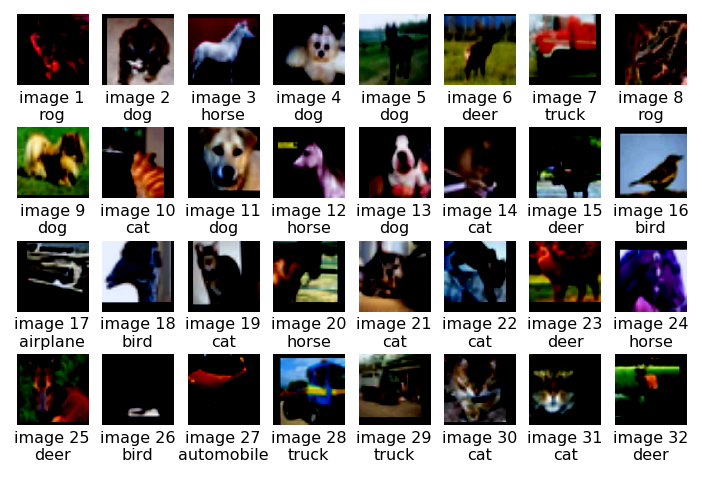

In [4]:
from matplotlib import pyplot as plt
import numpy as np

label_list = ["airplane", "automobile", "bird", "cat", "deer", "dog", "rog", "horse", "ship", "truck"]
print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
ds_iterator.get_next()
batch_1 = ds_iterator.get_next()
batch_image = batch_1["image"]
batch_label = batch_1["label"]
%matplotlib inline
plt.figure(dpi=144)
for i,image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    image = np.transpose(image,(1,2,0))
    plt.imshow(image)
    num = batch_label[i]
    plt.title(f"image {i+1}\n{label_list[num]}", y=-0.65, fontdict={"fontsize":8})
    plt.axis('off')    
plt.show()

## 网络初始化

在进行训练之前，需定义神经网络模型，本流程采用AlexNet网络，以下一段代码中定义AlexNet网络结构。

在AlexNet网络中使用`Summary`算子记录输入图像和张量数据。

- 使用`ImageSummary`记录输入图像数据。

    1. 在`__init__`方法中初始化`ImageSummary`。
        
        ```python
        # Init ImageSummary
        self.sm_image = P.ImageSummary()
        ```
    
    2. 在`construct`方法中使用`ImageSummary`算子记录输入图像。其中"Image"为MindInsight展示的记录到的图像信息面板标题。
    
        ```python
        # Record image by Summary operator
        self.sm_image("Image", x)
        ```
        
- 使用`TensorSummary`记录张量数据。

    1. 在`__init__`方法中初始化`TensorSummary`。
        
        ```python
        # Init TensorSummary
        self.sm_tensor = P.TensorSummary()
        ```
        
    2. 在`construct`方法中使用`TensorSummary`算子记录张量数据。其中"Tensor"为MindInsight展示的记录到的张量信息面板标题。
    
        ```python
        # Record tensor by Summary operator
        self.sm_tensor("Tensor", x)
        ```

In [5]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal
from mindspore.ops import operations as P

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="valid"):
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode=pad_mode)

def fc_with_initialize(input_channels, out_channels):
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

def weight_variable():
    return TruncatedNormal(0.02)


class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = P.MaxPool(ksize=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)
        # Init TensorSummary
        self.sm_tensor = P.TensorSummary()
        # Init ImageSummary
        self.sm_image = P.ImageSummary()

    def construct(self, x):
        # Record image by Summary operator
        self.sm_image("Image", x)
        x = self.conv1(x)
        # Record tensor by Summary operator
        self.sm_tensor("Tensor", x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## 记录标量、直方图、图像

本次体验中使用`SummaryCollector`来记录标量、直方图信息。

在MindSpore中通过`Callback`机制，提供支持快速简易地收集损失值、参数权重、梯度等信息的`Callback`, 叫做`SummaryCollector`（详细的用法可以参考API文档中`mindspore.train.callback.SummaryCollector`）。`SummaryCollector`使用方法如下： 

1. 为了记录损失值标量、直方图信息，在下面一段代码中需要在`specified`参数中指定需要记录的信息。

    ```python
    specified={"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*"}
    ```
    - 其中：
        - `"collect_metric"`为记录损失值标量信息。
        - `"histogram_regular"`为记录`conv1`层和`conv2`层直方图信息。

2. 实例化`SummaryCollector`，并将其应用到`model.train`或者`model.eval`中。

    ```python
    summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_01", 
                                         collect_specified_data=specified, 
                                         collect_freq=1, 
                                         keep_default_action=False, 
                                         collect_tensor_freq=200)
    ```
    -  其中：
        - `summary_dir`：指定日志保存的路径。
        - `collect_specified_data`：指定需要记录的信息。
        - `collect_freq`：指定使用`SummaryCollector`记录数据的频率。
        - `keep_default_action`：指定是否除记录除指定信息外的其他数据信息。
        - `collect_tensor_freq`：指定记录张量信息的频率。

&emsp;&emsp;程序运行过程中将在本地`8080`端口自动启动MindInsight服务并自动遍历读取当前notebook目录下`summary_dir`子目录下所有日志文件、解析进行可视化展示。

### 导入模块

In [6]:
import os
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.train.callback import SummaryCollector
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor

### 定义学习率

以下一段代码定义学习率。

In [7]:
import numpy as np


def get_lr(current_step, lr_max, total_epochs, steps_per_epoch):
    """
    generate learning rate array

    Args:
       current_step(int): current steps of the training
       lr_max(float): max learning rate
       total_epochs(int): total epoch of training
       steps_per_epoch(int): steps of one epoch

    Returns:
       np.array, learning rate array
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    decay_epoch_index = [0.8 * total_steps]
    for i in range(total_steps):
        if i < decay_epoch_index[0]:
            lr = lr_max
        else:
            lr = lr_max * 0.1
        lr_each_step.append(lr)
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate

lr = Tensor(get_lr(0, 0.002, 10, ds_train.get_dataset_size()))

### 执行训练

In [8]:
summary_base_dir = "./summary_dir"
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
os.system(f"mindinsight start --summary-base-dir  {summary_base_dir} --port=8080")
# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*"}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_01", collect_specified_data=specified, collect_freq=1, keep_default_action=False, collect_tensor_freq=200)
print("============== Starting Training ==============")
# Note: dataset_sink_mode should be set to False, else you should modify collect freq in SummaryCollector
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_alexnet-10_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3056953
epoch: 1 step: 2, loss is 2.3169184
epoch: 1 step: 3, loss is 2.2732773
epoch: 1 step: 4, loss is 2.3223817
epoch: 1 step: 5, loss is 2.300379
epoch: 1 step: 6, loss is 2.2816362
epoch: 1 step: 7, loss is 2.3317387
epoch: 1 step: 8, loss is 2.2595024
epoch: 1 step: 9, loss is 2.3138928
epoch: 1 step: 10, loss is 2.294712

...

epoch: 10 step: 1553, loss is 0.23232733
epoch: 10 step: 1554, loss is 0.35622978
epoch: 10 step: 1555, loss is 0.24221122
epoch: 10 step: 1556, loss is 0.2082262
epoch: 10 step: 1557, loss is 0.29972154
epoch: 10 step: 1558, loss is 0.32628897
epoch: 10 step: 1559, loss is 0.44762093
epoch: 10 step: 1560, loss is 0.4621265
epoch: 10 step: 1561, loss is 0.13807176
epoch: 10 step: 1562, loss is 0.40322578
Epoch time: 242827.643, per step time: 155.459
============== Starting Testing ==============
============== {'Accuracy': 0.8299278846153846} ==============


## MindInsight看板

在本地浏览器中打开地址：`127.0.0.1:8080`，进入到可视化面板。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/mindinsight_panel.png)

在上图所示面板中可以看到`summary_01`日志文件目录，点击**训练看板**进入到下图所示的训练数据展示面板，该面板展示了标量数据、直方图、图像和张量信息，并随着训练、测试的进行实时刷新数据，实时显示训练过程参数的变化情况。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/mindinsight_panel2.png)

### 标量可视化

标量可视化用于展示训练过程中标量的变化趋势情况，点击打开标量信息展示面板，该面板记录了迭代计算过程中的损失值标量信息，如下图展示了loss值标量趋势图。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/scalar_panel.png)

上图展示了神经网络在训练过程中loss值的变化过程。横坐标是训练步骤，纵坐标是loss值。

图中右上角有几个按钮功能，从左到右功能分别是全屏展示，切换Y轴比例，开启/关闭框选，分步回退和还原图形。

- 全屏展示即全屏展示该标量曲线，再点击一次即可恢复。
- 切换Y轴比例是指可以将Y轴坐标进行对数转换。
- 开启/关闭框选是指可以框选图中部分区域，并放大查看该区域，可以在已放大的图形上叠加框选。
- 分步回退是指对同一个区域连续框选并放大查看时，可以逐步撤销操作。
- 还原图形是指进行了多次框选后，点击此按钮可以将图还原回原始状态。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/scalar_select.png)

上图展示的标量可视化的功能区，提供了根据选择不同标签，水平轴的不同维度和平滑度来查看标量信息的功能。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。
- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。
- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。
- 标量合成：可以选中两条标量曲线进行合成并展示在一个图中，以方便对两条曲线进行对比或者查看合成后的图。
  标量合成的功能区与标量可视化的功能区相似。其中与标量可视化功能区不一样的地方，在于标签选择时，标量合成功能最多只能同时选择两个标签，将其曲线合成并展示。

### 直方图可视化


直方图用于将用户所指定的张量以直方图的形式展示。点击打开直方图展示面板，以直方图的形式记录了在迭代过程中所有层参数分布信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_panel.png)

如下图为`conv1`层参数分布信息，点击图中右上角，可以将图放大。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram.png)

下图为直方图功能区。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/imagesimages/histogram_func.png)

上图展示直方图的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的直方图。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

### 图像可视化

图像可视化用于展示用户所指定的图片。点击图像展示面板，展示了每个一步进行处理的图像信息。

下图为展示`summary_01`记录的图像信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_panel.png)

通过滑动上图中的"步骤"滑条，查看不同步骤的图片。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_function.png)

上图展示图像可视化的功能区，提供了选择查看不同标签，不同亮度和不同对比度来查看图片信息。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的图片信息。
- 亮度调整：可以调整所展示的所有图片亮度。
- 对比度调整：可以调整所展示的所有图片对比度。

### 张量可视化

张量可视化用于将张量以表格以及直方图的形式进行展示。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/tensor_func.png)

上图展示了张量可视化的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的表格数据或者直方图。
- 视图：可以选择表格或者直方图来展示tensor数据。在直方图视图下存在纵轴和视角的功能选择。
- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。
- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指 偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/tensor.png)

上图中将用户所记录的张量以表格的形式展示，包含以下功能：

- 点击表格右边小方框按钮，可以将表格放大。
- 表格中白色方框显示当前展示的是哪个维度下的张量数据，其中冒号":"表示当前维度的所有值，可以在方框输入对应的索引或者:后按Enter键或者点击后边的打勾按钮来查询特定维度的张量数据。 假设某维度是32，则其索引范围是-32到31。注意：可以查询0维到2维的张量数据，不支持查询超过两维的张量数据，即不能设置超过两个冒号":"的查询条件。
- 拖拽表格下方的空心圆圈可以查询特定步骤的张量数据。


## 单独记录数据

以上流程为整体展示Summary算子能记录到的所有类型数据，也可以单独记录关心的数据，以降低性能开销和日志文件大小。

### 单独记录损失值标量

1. 配置`specified`参数为：

```python
specified={"collect_metric": True}
```

2. 配置`summary_collector`为：

```python
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_loss_only", 
                                     collect_specified_data=specified, 
                                     collect_freq=1, 
                                     keep_default_action=False)
```

&emsp;&emsp;运行以下一段代码，单独记录损失值标量信息。

In [9]:
class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = P.MaxPool(ksize=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

lr = Tensor(get_lr(0, 0.002, 10, ds_train.get_dataset_size()))
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"collect_metric": True}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_loss_only", collect_specified_data=specified, collect_freq=1, keep_default_action=False)
print("============== Starting Training ==============")
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_alexnet_1-10_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.316685
epoch: 1 step: 2, loss is 2.3051994
epoch: 1 step: 3, loss is 2.2948198
epoch: 1 step: 4, loss is 2.3207984
epoch: 1 step: 5, loss is 2.3364246
epoch: 1 step: 6, loss is 2.2956452
epoch: 1 step: 7, loss is 2.2634928
epoch: 1 step: 8, loss is 2.3085115
epoch: 1 step: 9, loss is 2.254295
epoch: 1 step: 10, loss is 2.3339896

...

epoch: 10 step: 1556, loss is 0.40271574
epoch: 10 step: 1557, loss is 0.5172653
epoch: 10 step: 1558, loss is 0.3401278
epoch: 10 step: 1559, loss is 0.4081525
epoch: 10 step: 1560, loss is 0.31565452
epoch: 10 step: 1561, loss is 0.41298962
epoch: 10 step: 1562, loss is 0.24210417
Epoch time: 54385.175, per step time: 34.818
============== Starting Testing ==============
============== {'Accuracy': 0.8254206730769231} ==============


此时点击打开MindInsight**训练列表**看板中的`./summary_loss_only`目录，如下图所示，可以看到只记录有损失值标量信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/loss_scalar_only.png)

### 单独记录参数分布直方图

1. 配置`specified`参数为只记录`conv1`层直方图信息：

```python
specified = {"histogram_regular": "^conv1.*"}
```
2. 配置`summary_collector`为：

```python
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_histogram_only", 
                                     collect_specified_data=specified, 
                                     collect_freq=1,
                                     keep_default_action=False)
```

&emsp;&emsp;运行以下一段代码记录`conv1`层参数直方图信息（为了减少内存占用和减少训练时间，在后续的训练中设置`epoch`为1）。

In [10]:
lr = Tensor(get_lr(0, 0.002, 1, ds_train.get_dataset_size()))
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"histogram_regular": "^conv1.*"}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_histogram_only", collect_specified_data=specified, collect_freq=1, keep_default_action=False)
print("============== Starting Training ==============")
model.train(epoch=1, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_alexnet_2-1_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.2941067
epoch: 1 step: 2, loss is 2.2770133
epoch: 1 step: 3, loss is 2.2869372
epoch: 1 step: 4, loss is 2.261474
epoch: 1 step: 5, loss is 2.3582025
epoch: 1 step: 6, loss is 2.290377
epoch: 1 step: 7, loss is 2.2761602
epoch: 1 step: 8, loss is 2.3452077
epoch: 1 step: 9, loss is 2.2613692
epoch: 1 step: 10, loss is 2.3617961

...

epoch: 1 step: 1552, loss is 0.9691028
epoch: 1 step: 1553, loss is 1.1841048
epoch: 1 step: 1554, loss is 1.3479778
epoch: 1 step: 1555, loss is 1.2386065
epoch: 1 step: 1556, loss is 1.0223479
epoch: 1 step: 1557, loss is 1.1582826
epoch: 1 step: 1558, loss is 0.87887794
epoch: 1 step: 1559, loss is 0.956085
epoch: 1 step: 1560, loss is 1.3973256
epoch: 1 step: 1561, loss is 1.234511
epoch: 1 step: 1562, loss is 1.0787828
Epoch time: 62971.025, per step time: 40.314
============== Starting Testing ==============
============== {'Accuracy': 0.5687099358974359} ==============


此时点击打开MindInsight**训练列表**看板中的`./summary_histogram_only`目录。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_only.png)

在MindInsight面板中，如上图所示，只展示了直方图信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_only_all.png)

点击进入直方图面板，如上图所示，只展示了`conv1`层的直方图信息。

### 单独记录张量数据

1. 在AlexNet网络的`__init__`方法中初始化`ImageSummary`。
2. 在AlexNet网络的`construct`方法中使用`ImageSummary`算子记录输入图像。
3. 配置`summary_collector`为：

```python
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_tensor_only", 
                                     collect_specified_data=None, 
                                     collect_freq=1,
                                     keep_default_action=False, 
                                     collect_tensor_freq=50)
```

&emsp;&emsp;运行以下一段代码只记录张量数据。


In [11]:
class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = P.MaxPool(ksize=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)
        # Init TensorSummary
        self.sm_tensor = P.TensorSummary()

    def construct(self, x):
        x = self.conv1(x)
        # Record tensor by Summary operator
        self.sm_tensor("Tensor", x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

lr = Tensor(get_lr(0, 0.002, 1, ds_train.get_dataset_size()))
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
# Init a SummaryCollector callback instance, and use it in model.train or model.eval
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_tensor_only", collect_specified_data=None, collect_freq=1, keep_default_action=False, collect_tensor_freq=50)
print("============== Starting Training ==============")
model.train(epoch=1, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_alexnet_3-1_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3178232
epoch: 1 step: 2, loss is 2.3172731
epoch: 1 step: 3, loss is 2.3256557
epoch: 1 step: 4, loss is 2.3034613
epoch: 1 step: 5, loss is 2.318819
epoch: 1 step: 6, loss is 2.2775433
epoch: 1 step: 7, loss is 2.322216
epoch: 1 step: 8, loss is 2.2980762
epoch: 1 step: 9, loss is 2.3208668
epoch: 1 step: 10, loss is 2.3162236

...

epoch: 1 step: 1552, loss is 1.5239879
epoch: 1 step: 1553, loss is 1.3195564
epoch: 1 step: 1554, loss is 1.2827079
epoch: 1 step: 1555, loss is 1.0843871
epoch: 1 step: 1556, loss is 1.2715582
epoch: 1 step: 1557, loss is 1.4982214
epoch: 1 step: 1558, loss is 1.0394028
epoch: 1 step: 1559, loss is 1.0470619
epoch: 1 step: 1560, loss is 1.1495018
epoch: 1 step: 1561, loss is 1.0332686
epoch: 1 step: 1562, loss is 1.1649165
Epoch time: 113988.939, per step time: 72.976
============== Starting Testing ==============
============== {'Accuracy': 0.5647035256410257} ==============


此时点击打开MindInsight**训练列表**看板中的`./summary_tensor_only`目录，如下图所示，可以看到只记录有张量信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/tensor_only.png)

### 单独记录图像

1. 在AlexNet网络的`__init__`方法中初始化`ImageSummary`。
2. 在AlexNet网络的`construct`方法中使用`ImageSummary`算子记录输入的图像。
3. 配置`summary_collector`为：

    ```python
    summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_image_only", 
                                         collect_specified_data=None, 
                                         collect_freq=1, 
                                         keep_default_action=False)
    ```

&emsp;&emsp;运行以下一段代码只记录张量数据。

In [12]:
class AlexNet(nn.Cell):
    """
    Alexnet
    """
    def __init__(self, num_classes=10, channel=3):
        super(AlexNet, self).__init__()
        self.conv1 = conv(channel, 96, 11, stride=4)
        self.conv2 = conv(96, 256, 5, pad_mode="same")
        self.conv3 = conv(256, 384, 3, pad_mode="same")
        self.conv4 = conv(384, 384, 3, pad_mode="same")
        self.conv5 = conv(384, 256, 3, pad_mode="same")
        self.relu = nn.ReLU()
        self.max_pool2d = P.MaxPool(ksize=3, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = fc_with_initialize(6*6*256, 4096)
        self.fc2 = fc_with_initialize(4096, 4096)
        self.fc3 = fc_with_initialize(4096, num_classes)
        # Init ImageSummary
        self.sm_image = P.ImageSummary()

    def construct(self, x):
        # Record image by Summary operator
        self.sm_image("Image", x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

lr = Tensor(get_lr(0, 0.002, 1, ds_train.get_dataset_size()))
network = AlexNet(num_classes=10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=lr, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_alexnet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
# Init a SummaryCollector callback instance, and use it in model.train or model.eval
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_image_only", collect_specified_data=None, collect_freq=1, keep_default_action=False)
print("============== Starting Training ==============")
model.train(epoch=1, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=True)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_alexnet_4-1_1562.ckpt")
load_param_into_net(network, param_dict)
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=True)
print("============== {} ==============".format(acc))

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3218322
epoch: 1 step: 2, loss is 2.3194063
epoch: 1 step: 3, loss is 2.3358874
epoch: 1 step: 4, loss is 2.3217764
epoch: 1 step: 5, loss is 2.3040292
epoch: 1 step: 6, loss is 2.2832437
epoch: 1 step: 7, loss is 2.31645
epoch: 1 step: 8, loss is 2.3330472
epoch: 1 step: 9, loss is 2.3014827
epoch: 1 step: 10, loss is 2.310499

...

epoch: 1 step: 1552, loss is 1.293778
epoch: 1 step: 1553, loss is 1.385756
epoch: 1 step: 1554, loss is 1.2190051
epoch: 1 step: 1555, loss is 1.2079114
epoch: 1 step: 1556, loss is 1.0067248
epoch: 1 step: 1557, loss is 1.2732614
epoch: 1 step: 1558, loss is 1.0397598
epoch: 1 step: 1559, loss is 1.1968248
epoch: 1 step: 1560, loss is 1.2161392
epoch: 1 step: 1561, loss is 1.135769
epoch: 1 step: 1562, loss is 1.4535972
Epoch time: 152835.351, per step time: 97.846
============== Starting Testing ==============
============== {'Accuracy': 0.5597956730769231} ==============


![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_only.png)

在MindInsight面板中，如上图所示，只展示了输入图像信息。

### 对比看板

对比看板可视用于多次训练之间的标量数据对比。

点击MindInsight看板中的**对比看板**，打开对比看板，可以得到多次（不同）训练搜集到的标量数据对比信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/multi_scalars.png)

上图展示了`summary_01`（上图中红色曲线）和`summary_loss_only`（上图中蓝色曲线）的标量曲线对比效果，横坐标是训练步骤，纵坐标是标量值。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/multi_scalars_select.png)

上图展示的对比看板可视的功能区，提供了根据选择不同训练或标签，水平轴的不同维度和平滑度来进行标量对比的功能。

- 训练：提供了对所有训练进行多项选择的功能，用户可以通过勾选或关键字筛选所需的训练。
- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。
- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。
- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。

## 关闭MindInsight服务

在终端命令行中执行以下代码关闭MindInsight服务。

```shell
mindinsight stop --port 8080
```

## 注意事项和规格

- 为了控制列出summary列表的用时，MindInsight最多支持发现999个summary列表条目。
- 为了控制内存占用，MindInsight对标签（tag）数目和步骤（step）数目进行了限制：

    - 每个训练看板的最大标签数量为300个标签。标量标签、图片标签、计算图标签、参数分布图（直方图）标签的数量总和不得超过300个。特别地，每个训练看板最多有10个计算图标签。当实际标签数量超过这一限制时，将依照MindInsight的处理顺序，保留最近处理的300个标签。
    - 每个训练看板的每个标量标签最多有1000个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    - 每个训练看板的每个图片标签最多有10个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。 
    - 每个训练看板的每个参数分布图（直方图）标签最多有50个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    
- 出于性能上的考虑，MindInsight对比看板使用缓存机制加载训练的标量曲线数据，并进行以下限制：
    
    - 对比看板只支持在缓存中的训练进行比较标量曲线对比。    
    - 缓存最多保留最新（按修改时间排列）的15个训练。    
    - 用户最多同时对比5个训练的标量曲线。
    
- 由于张量可视（`TensorSummary`）会记录原始张量数据，需要的存储空间较大。使用`TensorSummary`前和训练过程中请注意检查系统存储空间充足。 通过以下方法可以降低张量可视功能的存储空间占用：

    - 避免使用`TensorSummary`记录较大的Tensor。
    - 减少网络中`TensorSummary`算子的使用个数。
    - 功能使用完毕后，请及时清理不再需要的训练日志，以释放磁盘空间。

备注：估算`TensorSummary`空间使用量的方法如下：

- 一个T`ensorSummary`数据的大小 ＝ Tensor中的数值个数 * 4 bytes。假设使用`TensorSummary`记录的Tensor大小为32 * 1 * 256 * 256，则一个TensorSummary数据大约需要32 * 1 * 256 * 256 * 4 bytes = 8,388,608 bytes = 8MiB。又假设SummaryCollector的`collect_freq`设置为1，且训练了50个迭代。则记录这50组数据需要的空间约为50 * 8 MiB ＝ 400MiB。需要注意的是，由于数据结构等因素的开销，实际使用的存储空间会略大于400MiB。
- 当使用`TensorSummary`时，由于记录完整Tensor数据，训练日志文件较大，MindInsight需要更多时间解析训练日志文件，请耐心等待。

## 总结

本次体验流程为完整的MindSpore深度学习及MindInsight可视化展示的过程，包括了下载数据集及预处理过程，构建网络、损失函数和优化器过程，生成模型并进行训练、验证的过程，以及启动MindInsight服务进行训练过程可视化展示。读者可以基于本次体验流程构建自己的网络模型进行训练，并使用`SummaryCollector`、`ImageSummary`和`TensorSummary`记录关心的数据，然后在MindInsight服务看板中进行可视化展示，根据MindInsight服务中展示的结果调整相应的参数以提高训练精度。

以上便完成了标量、直方图、图像和张量可视化的体验，我们通过本次体验全面了解了MindSpore执行训练的过程和MindInsight在标量、直方图、图像和张量可视化的应用，理解了如何使用`SummaryColletor`记录训练过程中的标量、直方图、图像和张量数据。